# imports

In [1]:
import warnings
import copy
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import minimize

from sklearn.metrics import  (f1_score,
                              roc_auc_score,
                              mean_squared_error,
                              make_scorer,
                              mean_absolute_error
                             )
from sklearn.preprocessing import StandardScaler,MinMaxScaler, OneHotEncoder
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    ShuffleSplit,
    StratifiedKFold,
    )
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier

from sklearn.linear_model import LogisticRegression , RidgeClassifier
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier


from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import optuna

In [2]:
RANDOM_SEED = 777
PATH = '/kaggle/input/playground-series-s3e18/'

# Load Data

In [3]:
#load train(df) and test(df_test) data
df = pd.read_csv(f'{PATH}train.csv').drop(['id','EC3','EC4','EC5','EC6'], axis = 1)
df_test = pd.read_csv(f'{PATH}test.csv').drop(['id'], axis = 1)

df_submisson = pd.read_csv(f'{PATH}sample_submission.csv')

#load origin data
df_mixed_desc = pd.read_csv('/kaggle/input/ec-mixed-class/mixed_desc.csv')

# new columns for orign data
df_mixed_desc['EC1'] = df_mixed_desc['EC1_EC2_EC3_EC4_EC5_EC6'].map(lambda x:int(x.split('_')[0]))
df_mixed_desc['EC2'] = df_mixed_desc['EC1_EC2_EC3_EC4_EC5_EC6'].map(lambda x:int(x.split('_')[1]))

#drop unnecessary columns
df_mixed_desc = df_mixed_desc[df.columns]  
df_mixed_desc.head(2)

#concat train data and origin
df = pd.concat([df, df_mixed_desc], ignore_index=True)
df = df.drop_duplicates()


# #removal hight outliners
columns_outliners = ['BertzCT', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3v', 'Chi4n',
                     'ExactMolWt', 'HeavyAtomMolWt','MaxAbsEStateIndex', 'MinEStateIndex',
                     'PEOE_VSA6','SMR_VSA10', 'SMR_VSA5']
for i in columns_outliners:
    df = df[df[i] <= df_test[i].max() * 1.01]

#removal low outliners
for i in range (1,4):
    df = df[ df[f'FpDensityMorgan{i}'] >= df_test[f'FpDensityMorgan{i}'].min() * 1.05 ]

#replacement outliners    
#for i in range(1, 4):
#    condition = df[f'FpDensityMorgan{i}'] >= df_test[f'FpDensityMorgan{i}'].min() * 1.05
#    mean_value = df[condition][f'FpDensityMorgan{i}'].mean()
 #   df[f'FpDensityMorgan{i}'] = df[f'FpDensityMorgan{i}'].where(condition, mean_value)


# shuffle 
df = df.sample(frac=1,random_state=RANDOM_SEED).reset_index(drop=True)

target_cols = ['EC1', 'EC2']
X = df.drop(target_cols, axis=1)

In [19]:
# логарифмировние
def def_log_df(df):
    
    columns_for_log = ['BertzCT', 'Chi1','Chi1n', 'Chi2n' , 'Chi2v', 
                   'Chi3v', 'Chi4n', 'EState_VSA1', 'EState_VSA2',
                   'ExactMolWt', 'HeavyAtomMolWt' ,'PEOE_VSA14',  'Kappa3',
                   'PEOE_VSA6', 'PEOE_VSA7' ,'SMR_VSA5' ,'VSA_EState9'
                      ]
    for i in  columns_for_log :
      df[i] = np.log1p(df[i])
    #df = df.dropna(axis=0)
    df = df.reset_index(drop=True)
    return df
#Kappa 3  выдает 184 NAN после логарифмирования
#'VSA_EState9' 6 шт
# на тесте все ок
#df = def_log_df(df)
#df_test = def_log_df(df_test)

In [4]:
df.shape

(15772, 33)

In [6]:
df.head(3)

,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,EState_VSA2,...,PEOE_VSA7,PEOE_VSA8,SMR_VSA10,SMR_VSA5,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2,EC1,EC2
0,197.973416,6.010150,3.456598,3.456598,2.516894,2.516894,1.917655,0.898365,20.533545,6.606882,...,0.00000,0.000000,14.210589,6.103966,14.210589,39.666667,0,0,1,1
1,576.780996,10.096555,7.063324,7.063324,5.980044,5.980044,3.917843,2.332306,0.000000,11.499024,...,34.80282,5.687386,0.000000,96.119404,0.000000,42.166667,0,0,1,1
2,128.954618,4.631852,2.281282,3.320085,1.635041,2.383531,1.239132,0.283731,27.140427,0.000000,...,0.00000,0.000000,7.822697,6.606882,9.088795,19.739444,0,0,0,1


In [214]:
df_test.head(3)

,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,EState_VSA2,...,PEOE_VSA14,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,SMR_VSA10,SMR_VSA5,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2
0,344.632371,7.283603,4.473966,5.834958,3.412257,4.651530,2.096558,1.116433,49.458581,0.000000,...,13.512441,0.000000,0.000000,0.000000,26.809272,24.539800,4.794537,47.304082,1,1
1,1432.410201,10.663869,7.079026,8.065215,5.297097,5.297097,3.924155,2.569694,0.000000,29.783175,...,0.000000,34.947374,98.323987,9.606882,0.000000,53.378235,0.000000,43.166667,0,0
2,83.352608,3.931852,1.774215,1.774215,1.073446,1.073446,0.467830,0.170838,5.969305,6.420822,...,5.969305,0.000000,0.000000,6.420822,11.752550,13.344559,9.589074,24.666667,1,1


In [ ]:
df_submisson.head(3)

# EDA

In [212]:
#Check NANs
print("Nulls in train: ",df.isna().sum().max())
print("Nulls in test: ",df_test.isna().sum().max())

Nulls in train:  0
Nulls in test:  0


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15772 entries, 0 to 15771
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   BertzCT            15772 non-null  float64
 1   Chi1               15772 non-null  float64
 2   Chi1n              15772 non-null  float64
 3   Chi1v              15772 non-null  float64
 4   Chi2n              15772 non-null  float64
 5   Chi2v              15772 non-null  float64
 6   Chi3v              15772 non-null  float64
 7   Chi4n              15772 non-null  float64
 8   EState_VSA1        15772 non-null  float64
 9   EState_VSA2        15772 non-null  float64
 10  ExactMolWt         15772 non-null  float64
 11  FpDensityMorgan1   15772 non-null  float64
 12  FpDensityMorgan2   15772 non-null  float64
 13  FpDensityMorgan3   15772 non-null  float64
 14  HallKierAlpha      15772 non-null  float64
 15  HeavyAtomMolWt     15772 non-null  float64
 16  Kappa3             157

In [145]:
sorted(df['fr_COO'].unique())

[0, 1, 2, 3, 4, 5, 6, 8]

In [146]:
sorted(df['fr_COO2'].unique())

[0, 1, 2, 3, 4, 5, 6, 8]

In [147]:
df['NumHeteroatoms'].nunique()

42

In [148]:
df['EC1'].mean()

0.6656121480544132

In [149]:
df['EC2'].mean()

0.7956975640620056

## hist 

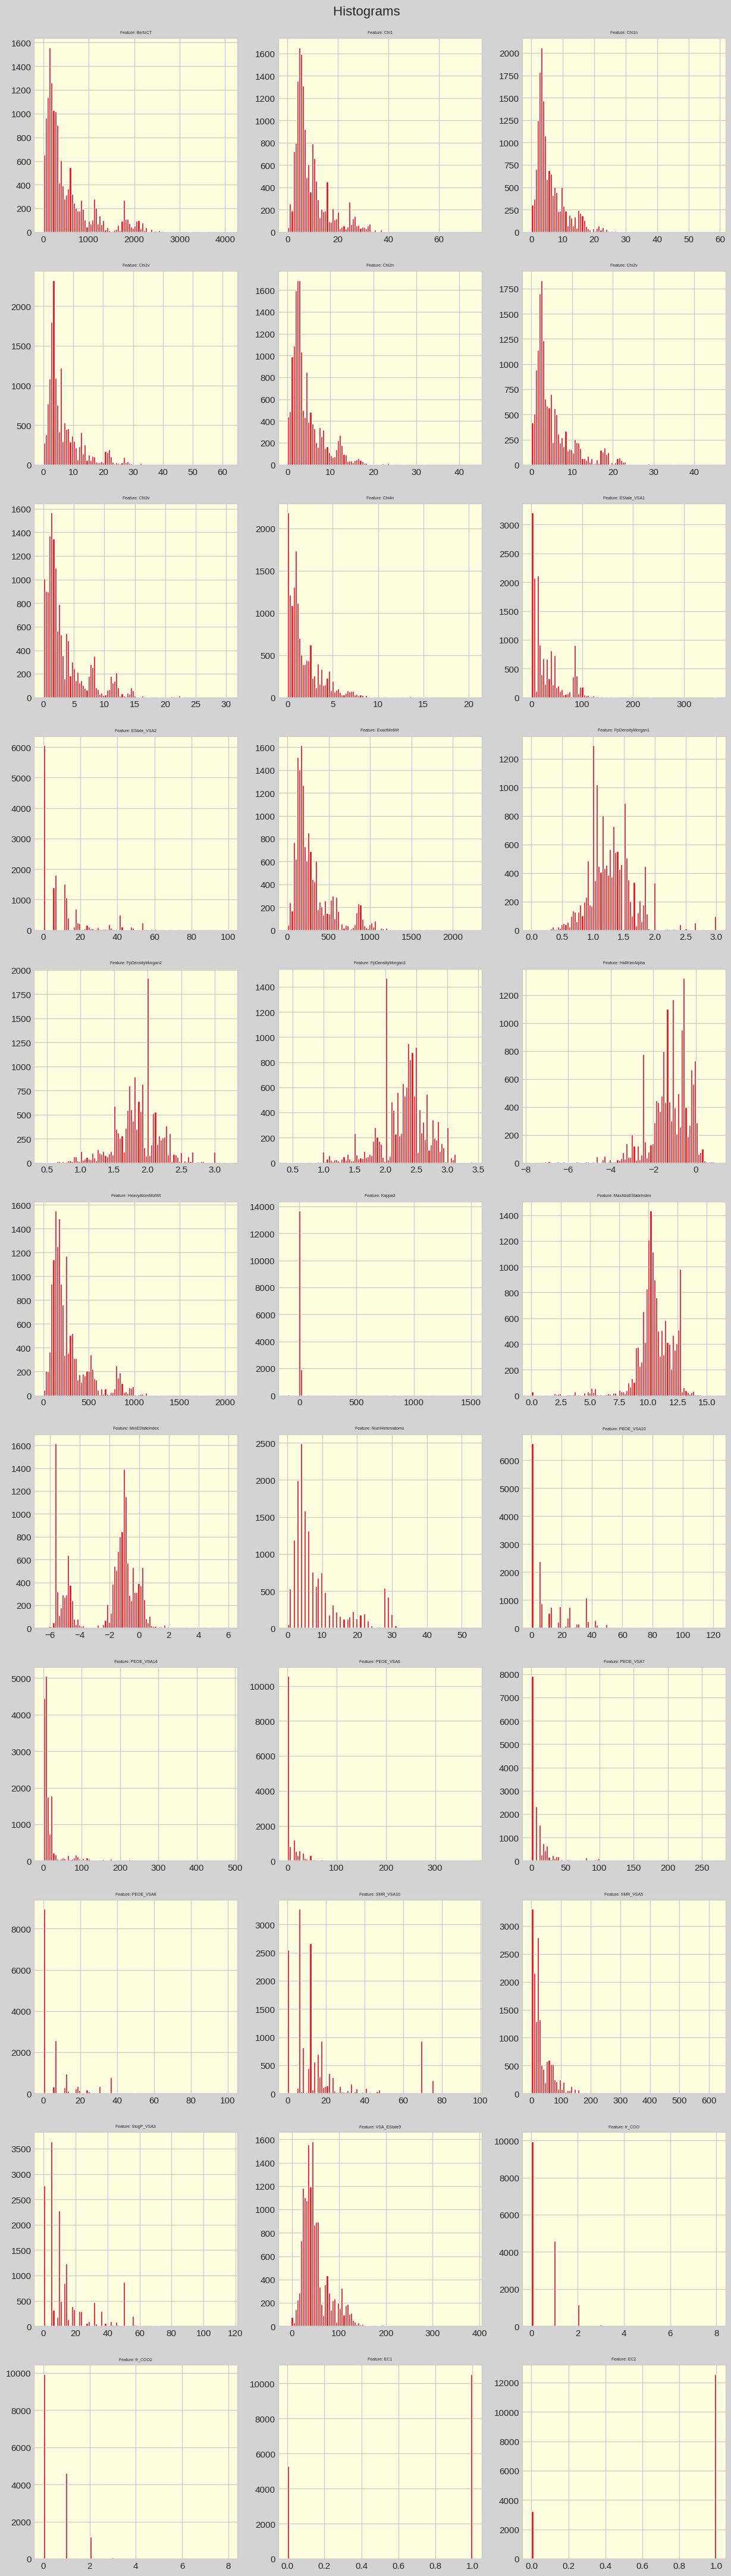

In [175]:
num_features  = df.select_dtypes(exclude='object').columns.to_list()
sns.set()
plt.style.use('seaborn-whitegrid') 
_, axs = plt.subplots(len(num_features) // 3, 3, figsize=(15,5* len(num_features) // 3), facecolor='lightgray')

for f, ax in zip(num_features, axs.ravel()):
    ax.set_facecolor('lightyellow')
    ax.hist(df[f], bins=100, color='red')
    ax.set_title(f'Feature: {f}', fontsize=5)

plt.suptitle('Histograms ', y=0.89, fontsize=16)
plt.show()

**Выбросы есть,проверим что на тест данных** 


## Outlier  
Посмотрим разницу между трен и тест датасеты, выкинем те выбросы из трейн ,ч то нет в тесте.

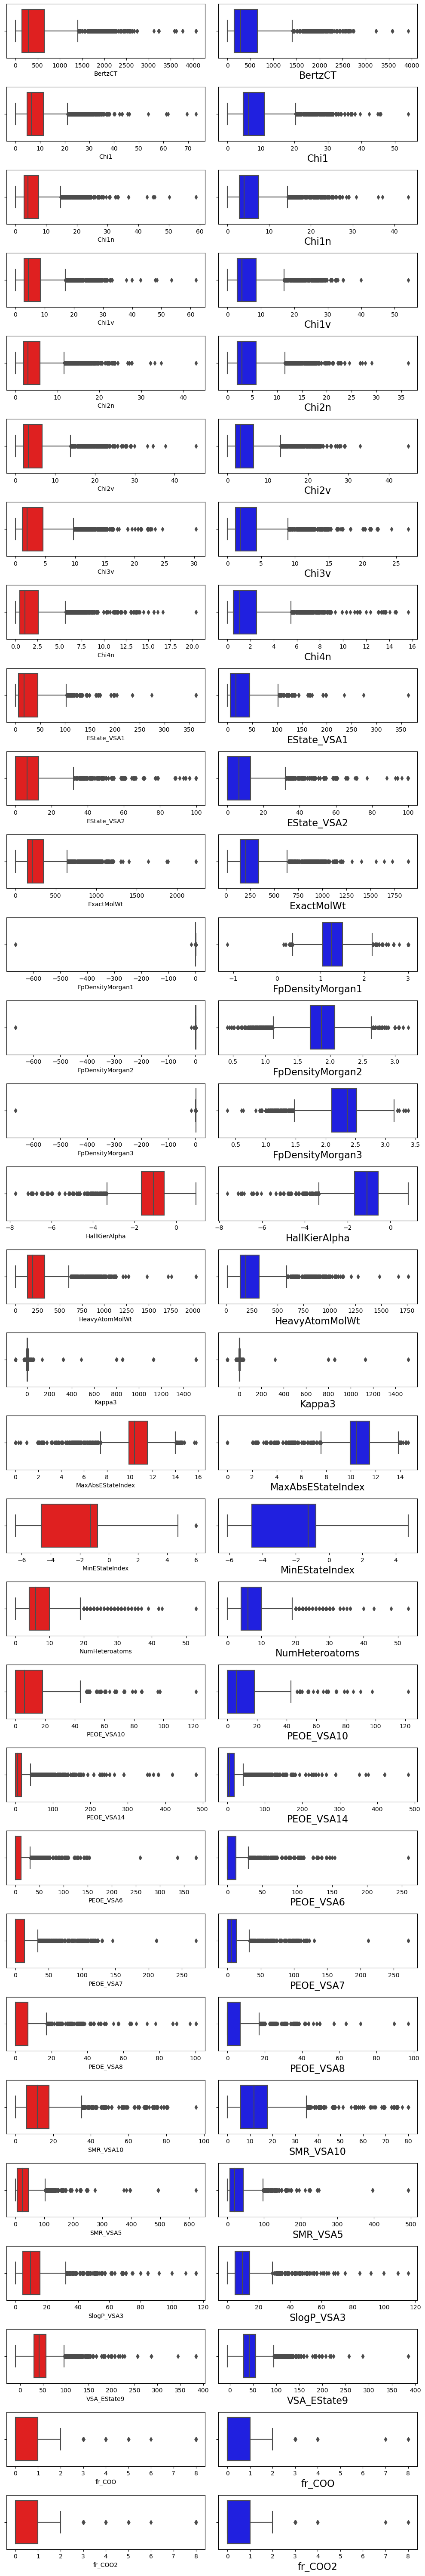

In [114]:
#box plot for train and tets data
fig, axes = plt.subplots(len(df_test.columns),2,figsize=(10, 60))

for i, column_name in enumerate(df_test.columns):
    plot = sns.boxplot(ax=axes[i,0],x = df[column_name], color = 'red')
    plot = sns.boxplot(ax=axes[i,1],x = df_test[column_name], color = 'blue')
    plot.set_xlabel(column_name, fontsize = 16)
    plt.tight_layout()

In [175]:
# #removal hight outliners
columns_outliners = ['BertzCT', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3v', 'Chi4n',
                     'ExactMolWt', 'HeavyAtomMolWt','MaxAbsEStateIndex', 'MinEStateIndex',
                     'PEOE_VSA6','SMR_VSA10', 'SMR_VSA5']
for i in columns_outliners:
    df = df[df[i] <= df_test[i].max() * 1.05]

#removal low outliners
for i in range (1,4):
    df = df[ df[f'FpDensityMorgan{i}'] >= df_test[f'FpDensityMorgan{i}'].min() * 1.05 ]

df = df.reset_index(drop=True)  

In [177]:
df

,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,EState_VSA2,...,PEOE_VSA7,PEOE_VSA8,SMR_VSA10,SMR_VSA5,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2,EC1,EC2
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.976640,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1,1
1,195.149324,5.287694,2.816497,2.816497,1.987767,1.987767,1.134602,0.440794,5.969305,5.749512,...,12.132734,0.000000,5.969305,6.420822,11.215359,33.666667,1,1,1,0
2,2058.814651,26.483420,16.300878,22.185628,12.712129,18.452070,12.072690,4.943217,84.554972,47.360206,...,24.265468,41.264263,80.742293,50.912063,45.902955,106.824047,0,0,1,0
3,358.521063,11.612591,8.990659,8.990659,5.912962,5.912962,3.827541,2.331931,12.145807,13.016977,...,0.000000,0.000000,6.410095,83.277761,0.000000,53.766029,0,0,1,1
4,158.340930,5.464102,2.928729,2.928729,2.034392,2.034392,1.611120,0.866546,24.146543,0.000000,...,0.000000,0.000000,11.938611,6.103966,9.589074,38.166667,2,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15776,391.227488,9.055461,6.499880,6.499880,6.097090,6.097090,3.261677,2.299833,0.000000,6.606882,...,0.000000,0.000000,0.000000,53.378235,9.088795,35.527357,0,0,0,1
15777,217.028307,5.519745,3.931598,3.931598,2.154560,2.154560,0.838983,0.665697,23.217841,0.000000,...,0.000000,12.132734,11.938611,12.462662,9.589074,39.166667,2,2,0,1
15778,150.118984,4.201907,2.841397,4.061119,1.605951,2.891113,1.749075,0.846003,0.000000,0.000000,...,0.000000,0.000000,17.744066,25.366431,4.794537,20.058935,0,0,1,1
15779,1947.769973,30.749437,19.886822,25.910380,14.868214,20.256270,13.283346,5.359866,90.658938,53.781027,...,6.420822,35.598365,69.141353,57.332884,50.697492,116.932262,0,0,1,1


# ML

## functions for MultiOutputClassifier


In [28]:
#
def ShuffleSplit_MultiOutput_auc(X,y,model_):
    ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
    auc_result = []
    for train, test   in ss.split(X):
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]
       
        model =  model_
        multioutput_classifier = MultiOutputClassifier(model)
        multioutput_classifier.fit(X_train, y_train)
    
        y_pred = np.array(multioutput_classifier.predict_proba(X_test))[:,:,1].T  
        auc_result.append(roc_auc_score(y_test,y_pred) )
    
        return np.mean(auc_result).round(5)

### LogisticRegression()  + MultiOutputClassifier
ShuffleSplit    
Нужно масштабирвоание тут, иначе варнинги и метрика лучше с масштабирвоанием.


In [87]:
scaler = StandardScaler()

X_scaler = scaler.fit_transform(X)
X_scaler = pd.DataFrame(X_scaler)
ShuffleSplit_MultiOutput_auc(X_scaler,y,LogisticRegression(max_iter=1000))
  


0.62677

###  many models on MultiOutput   
прогоним список моделей с мулититаргетом ,чтобы оценить метрики каждой

In [34]:
X = df.drop(target_cols, axis=1)
y = df[['EC1', 'EC2']]
models_multi_otput = {'AdaBoostClassifier':AdaBoostClassifier(),
                     'CatBoostClassifier':CatBoostClassifier(verbose=False),
                     'LGBMClassifier':LGBMClassifier(),
                     'XGBClassifier':XGBClassifier(),
                     'RandomForestClassifier':RandomForestClassifier(max_depth=8)
                    }

for  modelka in models_multi_otput:
   
    print(modelka,ShuffleSplit_MultiOutput_auc(X,y,models_multi_otput[modelka]))
    



AdaBoostClassifier 0.64434
CatBoostClassifier 0.64723
LGBMClassifier 0.63886
XGBClassifier 0.61977
RandomForestClassifier 0.65236


- AdaBoostClassifier 0.64479
- CatBoostClassifier 0.64304
- LGBMClassifier 0.64001
- XGBClassifier 0.62212
- RandomForestClassifier 0.6514

Лес max_depth=8 показывает себя лучше всех.   
XGB никакой, ниже ЛогРег

## solo target researh    
- сначала поработаем с фичами, пробуем повыкидывать слабые
- затем пробуем нагенерить новых
- работаем с каждой тарегт отдельно****

In [45]:
#ЛогРег
y = df['EC2']
#
steps = [
    ('scaler', StandardScaler()), 
    ('classifier', LogisticRegression(max_iter=1000))  
]
pipeline = Pipeline(steps)

scores = cross_val_score(pipeline, X, y, cv=5,scoring='roc_auc' )
scores.mean().round(5)

0.57246

1 target: default 0.67835,  
2 target: default 0.57376,

## Features impotant for LogReg   
при отбросе самых незначимых фичей, есть хорошие шансы увеличить метрику на логрег 

### EC2

In [68]:
# получим список фич имп. для ЛогРег для EC2

X_scaler = transform_df_scaler(df).drop(target_cols,axis=1)
y = df['EC2']
model = LogisticRegression(max_iter=1000)
model.fit(X_scaler ,y)
#список самых не значимых фичей
list_logreg_features_imp = pd.DataFrame(model.coef_.reshape(-1) * 100, index=X_scaler.columns).abs().sort_values(by=0, ascending=True).reset_index()['index'].to_list()

#Дропаем по 1 фичи снизу(самые незначимые), ищем макс метрику
list_scores_logreg = []
X_scaler = transform_df_scaler(df).drop(target_cols,axis=1)
for i in list_logreg_features_imp[:len(list_logreg_features_imp)-3]:
    X_scaler =  X_scaler.drop(i,axis=1)
    scores = cross_val_score(model, X_scaler, y, cv=5,scoring='roc_auc' )
    list_scores_logreg.append(scores.mean())
max(list_scores_logreg)

0.5769814831535357

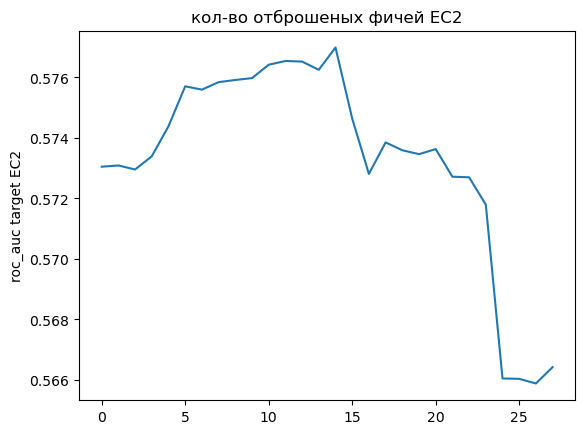

In [69]:
plt.plot(list_scores_logreg)
#plt.xlabel('Индекс')
plt.ylabel('roc_auc target EC2')
plt.title('кол-во отброшеных фичей EC2')
plt.show()

In [76]:
#провоерим
features_for_drop_logreg = list_logreg_features_imp[:list_scores_logreg.index(max(list_scores_logreg))+1]
X_scaler = transform_df_scaler(df).drop(target_cols,axis=1)
X_scaler =  X_scaler.drop(features_for_drop_logreg, axis=1)
model = LogisticRegression(max_iter=1000)
model.fit(X_scaler ,y)
scores = cross_val_score(model, X_scaler, y, cv=5,scoring='roc_auc' )
print('лучший скор на таргет EC2 на отсееных фичах',scores.mean())
print('')
print('фичи для лучшего скора',list(X_scaler.columns))
print('')
best_features_LogReg_EC1 = list(X_scaler.columns)

лучший скор на таргет EC2 на отсееных фичах 0.5769814831535357

фичи для лучшего скора ['BertzCT', 'Chi1', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3v', 'Chi4n', 'ExactMolWt', 'FpDensityMorgan2', 'MinEStateIndex', 'NumHeteroatoms', 'PEOE_VSA14', 'PEOE_VSA6', 'SMR_VSA10', 'SlogP_VSA3', 'fr_COO']



In [80]:
best_features_LogReg_EC2 = ['BertzCT', 'Chi1', 'Chi1v', 'Chi2n',
    'Chi2v', 'Chi3v', 'Chi4n', 'ExactMolWt', 'FpDensityMorgan2', 
    'MinEStateIndex', 'NumHeteroatoms', 'PEOE_VSA14', 'PEOE_VSA6',
    'SMR_VSA10', 'SlogP_VSA3', 'fr_COO']

def transform_df_scaler(df):
    scaler = StandardScaler()
    df_scaler = scaler.fit_transform(df)
    df_scaler = pd.DataFrame(df_scaler, columns=df.columns)
    return df_scaler
def transform_df_minmax_scaler(df):
    scaler = MinMaxScaler()
    df_scaler = scaler.fit_transform(df)
    df_scaler = pd.DataFrame(df_scaler, columns=df.columns)
    return df_scaler



In [306]:
model_list = {'AdaBoostClassifier':AdaBoostClassifier(),
                     'CatBoostClassifier':CatBoostClassifier(verbose=False),
                     'LGBMClassifier':LGBMClassifier(),
                     'XGBClassifier':XGBClassifier(),
                     'RandomForestClassifier':RandomForestClassifier(max_depth=8)
                    }
#cat_cols = ['fr_COO','fr_COO2','NumHeteroatoms'] 

y = df['EC1']
#X = df.drop(target_cols,axis=1)
#X = transform_df_scaler(df).drop(target_cols,axis=1)
X = transform_df_minmax_scaler(df).drop(target_cols,axis=1)

for modelka in model_list:
    model = model_list[modelka]
    scores = cross_val_score(model, X, y, cv=5,scoring='roc_auc' )
    print(modelka ,'roc_auc target1 = ', scores.mean().round(5) )

AdaBoostClassifier roc_auc target1 =  0.70302
CatBoostClassifier roc_auc target1 =  0.70803
LGBMClassifier roc_auc target1 =  0.70806
XGBClassifier roc_auc target1 =  0.68799
RandomForestClassifier roc_auc target1 =  0.71431


**Без скалера**  
- AdaBoostClassifier roc_auc target1 =  0.703
- CatBoostClassifier roc_auc target1 =  0.70928
- LGBMClassifier roc_auc target1 =  0.70477
- XGBClassifier roc_auc target1 =  0.68666
- RandomForestClassifier roc_auc target1 =  **0.71569**

**Скалер**
- AdaBoostClassifier roc_auc target1 =  0.703
- CatBoostClassifier roc_auc target1 =  0.70868
- LGBMClassifier roc_auc target1 =  0.70586
- XGBClassifier roc_auc target1 =  0.68904
- RandomForestClassifier roc_auc target1 =  **0.71502**    

**MinMaxScaler()**   
- AdaBoostClassifier roc_auc target1 =  0.70302
- CatBoostClassifier roc_auc target1 =  0.70803
- LGBMClassifier roc_auc target1 =  0.70806
- XGBClassifier roc_auc target1 =  0.68799
- RandomForestClassifier roc_auc target1 =  0.71431    
Лес самый лучший скор удерева , со скалером ил и без, причем  может поменяться при подборе     
MinMaxScaler()  улучшает  метрики для LGBM XGB  


In [307]:
y = df['EC2']
X = transform_df_minmax_scaler(df).drop(target_cols,axis=1)

for modelka in model_list:
    model = model_list[modelka]
    scores = cross_val_score(model, X, y, cv=5,scoring='roc_auc' )
    print(modelka ,'roc_auc target2 = ', scores.mean().round(5) )

AdaBoostClassifier roc_auc target2 =  0.58222
CatBoostClassifier roc_auc target2 =  0.57931
LGBMClassifier roc_auc target2 =  0.56833
XGBClassifier roc_auc target2 =  0.55782
RandomForestClassifier roc_auc target2 =  0.59029


**Без скалера:**       
- AdaBoostClassifier roc_auc target2 =  0.58275
- CatBoostClassifier roc_auc target2 =  0.57974
- LGBMClassifier roc_auc target2 =  0.57338
- XGBClassifier roc_auc target2 =  0.55956
- RandomForestClassifier roc_auc target2 =  0.59101 

**StandardScaler():**   
- AdaBoostClassifier roc_auc target2 =  0.58261
- CatBoostClassifier roc_auc target2 =  0.5802
- LGBMClassifier roc_auc target2 =  0.5683
- XGBClassifier roc_auc target2 =  0.55299
- RandomForestClassifier roc_auc target2 =  **0.59282** 

**MinMaxScaler():**     
- AdaBoostClassifier roc_auc target2 =  0.58222
- CatBoostClassifier roc_auc target2 =  0.57931
- LGBMClassifier roc_auc target2 =  0.56833
- XGBClassifier roc_auc target2 =  0.55782
- RandomForestClassifier roc_auc target2 =  0.59029

Сам лучше метрика ЛЕС со скалером стандартным.  
Бустинги все хуже со скалером, кроме кэт_буст  со стандартным   
Кэт буст это возможно погрешность инадо уже проверять на гипре параметрах.

## Function for df transform target

In [6]:
# здесь все функции преобразов дата сетов
 

#скалер
def transform_df_standard_scaler(df):
    X = df.drop(target_cols, axis=1)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = pd.DataFrame(X, columns=df.drop(target_cols, axis=1).columns)
    return X

def transform_df_minmax_scaler(df):
    scaler = MinMaxScaler()
    X = scaler.fit_transform(df)
    X = pd.DataFrame(X, columns=df.columns)
    return X

# кат фичи для LGBM
def transform_df_lgbm(df):
    X = df.drop(target_cols, axis=1)
    lgdm_cat_cols = [ 'fr_COO2', 'fr_COO']
    X[lgdm_cat_cols] = X[lgdm_cat_cols].astype('category')
    return X
#min max скалер и дроп для lgbm
def transform_df_scaler_lgbm(df):
    X = df.drop(target_cols, axis=1)
    X = X.drop([ 'fr_COO2',],axis=1)
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    return X

# для cat  не нужно


### catboost


In [96]:
%%time
#  оценим фичи импт по каждому таргету   #NumHeteroatoms
catboost_cat_cols = ['fr_COO','fr_COO2','NumHeteroatoms'] 
cat_features = ['fr_COO','fr_COO2','NumHeteroatoms']
y = df['EC2']
X = df.drop(target_cols,axis=1)

catboost_float_cols = X.drop(catboost_cat_cols,axis=1).columns
#X[catboost_float_cols] = scaler.fit_transform(X[catboost_float_cols])


model = CatBoostClassifier(verbose=False,cat_features=cat_features, **best_params_CAT_catfeat_EC2)
scores = cross_val_score(model, X, y, cv=5,scoring='roc_auc' )
scores.mean().round(5)


CPU times: user 1min 56s, sys: 12.7 s, total: 2min 9s
Wall time: 37 s


0.59358

- 1-я таргет дефолт кэт: ,**БЕЗскалер+кэт фичи 0.71102**, скалер+кэт фичи 0.71005 , без склера и кэт фичей 0.70928   

- 2-я таргет дефолт кэт:  **БЕЗскалер+кэт фичи 0.58311**, скалер+кэт фичи 0.57897 

 
 **Итого  такой вывод:** Без скалера +кэт_фич(3шт) = лучшая метрика

In [241]:
model.fit(X, y)
feature_importances_cat = pd.Series(model.feature_importances_, index=model.feature_names_).sort_values(ascending=False)
feature_importances_cat

NumHeteroatoms       6.666168
MaxAbsEStateIndex    5.253196
MinEStateIndex       4.747987
FpDensityMorgan2     4.502927
Kappa3               4.464815
FpDensityMorgan1     4.379129
EState_VSA1          4.139229
FpDensityMorgan3     3.942417
BertzCT              3.863380
SlogP_VSA3           3.689087
SMR_VSA10            3.554362
HallKierAlpha        3.493499
Chi1                 3.460799
VSA_EState9          3.440912
PEOE_VSA14           3.349302
SMR_VSA5             3.229556
EState_VSA2          3.220854
Chi4n                2.884184
Chi3v                2.811853
PEOE_VSA10           2.738464
PEOE_VSA8            2.517989
Chi2v                2.407042
HeavyAtomMolWt       2.390644
Chi1n                2.389222
Chi2n                2.385375
PEOE_VSA6            2.150023
PEOE_VSA7            2.056653
Chi1v                2.030948
ExactMolWt           1.998764
fr_COO2              1.273635
fr_COO               0.567586
dtype: float64

## LGBM    
исследуем руками

In [185]:
 #скалер и дроп для lgbm
y = df['EC2']
X = df.drop(target_cols, axis=1)

#X = transform_df_lgbm(df)
X = def_log_df(X) #<<<<<<< логарифмирование
model = LGBMClassifier() # best_params_LGBM_catfeat_EC2
scores = cross_val_score(model, X, y, cv=5,scoring='roc_auc' )
scores.mean().round(5)

0.57707

1таргет: 
- default  0.70477 
- default+drop fr_COO2 0.70569
- default+drop fr_COO+ fr_COO2 0.70515   
- default+catFeat_3  0.70447
- default+catFeat_2(COO_COO2) **0.70708**
- default+drop_COO= catFeat_2  0.70419 

1таргет со StandardScaler():  
- default 0.70586
- default+catFeat_2(COO_COO2)  0.7054

1таргет со MinMaxScaler(): 
- default **0.70806** 
- default+catFeat_2(COO_COO2)  0.70532
- default+drop fr_COO2 **0.70807**

#Лучшие паратметры   
 - scaler 0.71357
 - без скалер с 2 кат **0.7143**

2тарегт: 
- лучш метрика на 2категр без дропов  
0.59262 ка кни странно это параметры для EC1....     
0.59131 параметры для EC2    
0.59311 новый параметры EC2  сохранем  


In [285]:
model.fit(X,y)

feature_importances_lgmb = pd.Series(model.feature_importances_, index=df.drop(target_cols, axis=1).columns).sort_values(ascending=False)
feature_importances_lgmb

MinEStateIndex       173
Kappa3               159
MaxAbsEStateIndex    153
VSA_EState9          142
FpDensityMorgan3     142
FpDensityMorgan2     142
HallKierAlpha        132
SMR_VSA5             126
FpDensityMorgan1     126
BertzCT              116
Chi4n                112
Chi2n                108
SMR_VSA10             99
EState_VSA1           96
PEOE_VSA10            95
Chi3v                 94
PEOE_VSA8             90
Chi1n                 88
HeavyAtomMolWt        85
Chi1                  80
Chi2v                 80
SlogP_VSA3            79
ExactMolWt            77
Chi1v                 77
EState_VSA2           70
PEOE_VSA14            69
NumHeteroatoms        68
PEOE_VSA7             67
PEOE_VSA6             40
fr_COO                13
fr_COO2                2
dtype: int32

## Random Forest Cl

In [123]:

#X = transform_X_logreg(df)
y = df['EC1']
X = df.drop(target_cols,axis=1)
model = RandomForestClassifier (**best_params_RF_scaler_EC1 )#(**best_rmc_params_EC1)  max_depth=8
scores = cross_val_score(model, X, y, cv=5,scoring='roc_auc' )
scores.mean().round(5)

0.71629

In [124]:
best_params_RF_scaler_EC1

{'n_estimators': 890,
 'max_depth': 10,
 'min_samples_split': 3,
 'min_samples_leaf': 7,
 'random_state': 777}

Тарегет1:
Таргет2: стандарт скалер(минмакс чуть похуже    
0.71629 0.71592

In [ ]:
model.fit(X,y)

feature_importances_rf = pd.Series(model.feature_importances_ * 100, index=X.columns).sort_values(ascending=False)
feature_importances_rf

## AdaBoostClassifier

In [64]:
## 
y = df['EC2']
X = df.drop(target_cols,axis=1)
model = AdaBoostClassifier(**best_params_ADA_EC2)

# Оценка модели с использованием выбранной метрики (например, accuracy)
score = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
score.mean().round(5)

0.58746

- 0.7040957825798146 
- 0.5775488927959658   0.58394    
Слабо

## XGB

In [24]:
for i in target_cols:
    model = XGBClassifier()
    X = df.drop(target_cols,axis=1)
    y = df[i]
    score = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    print (f'roc_auc.mean for {i}', score.mean().round(5) )
    

roc_auc.mean for EC1 0.68014
roc_auc.mean for EC2 0.55175


- дефолт :  
roc_auc.mean for EC1 0.68283    
roc_auc.mean for EC2 0.55878   
- minmax scaler   
roc_auc.mean for EC1 0.68028       
roc_auc.mean for EC2 0.55276 

## Optuna hyperperams  tuning    
     

In [ ]:
#params optuna models

# взято у  кого то для cat параметры
 params  = {
        'learning_rate' : trial.suggest_float('learning_rate', .001, .1, log = True),
        'max_depth' : trial.suggest_int('max_depth', 2, 10),
        'subsample' : trial.suggest_float('subsample', .5, 1),
        'colsample_bylevel' : trial.suggest_float('colsample_bylevel', .1, 1),
        'min_child_samples' : trial.suggest_int('min_child_samples', 1, 15),
        'reg_lambda' : trial.suggest_float('reg_lambda', 0, 1),
        'n_estimators' : trial.suggest_int('n_estimators', 100, 1000),
        'random_state' : RANDOM_SEED,
        'bootstrap_type' : 'Bernoulli',
        #'verbose' : 0,
        'cat_features' : ['fr_COO','fr_COO2','NumHeteroatoms']
    }

    
    params_optuna_cat = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 3, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "used_ram_limit": "3gb",
        "eval_metric": "AUC",
        }
    params_optuna_rfc = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 5, 12),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
             }
        
    params_optuna_lgbm = {
        'num_leaves': trial.suggest_int('num_leaves', 10, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0),
        'max_depth': trial.suggest_int('max_depth', 5, 12),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
    }
    # для поиска рядом с лучшими параметрами
    params_optuna_lgbm = {
        'num_leaves': trial.suggest_int('num_leaves', best_params['num_leaves'] - 10, best_params['num_leaves'] + 10),
        'learning_rate': trial.suggest_float('learning_rate', best_params['learning_rate'] * 0.8, best_params['learning_rate'] * 1.2),
        'subsample': trial.suggest_float('subsample', best_params['subsample'] * 0.8, best_params['subsample'] * 1.2),
        'colsample_bytree': trial.suggest_float('colsample_bytree', best_params['colsample_bytree'] * 0.8, 0.99),
        'reg_alpha': trial.suggest_float('reg_alpha', best_params['reg_alpha'] * 0.8, best_params['reg_alpha'] * 1.2),
        'reg_lambda': trial.suggest_float('reg_lambda', best_params['reg_lambda'] * 0.8, best_params['reg_lambda'] * 1.2),
        'max_depth': trial.suggest_int('max_depth', best_params['max_depth'] - 3, best_params['max_depth'] + 3),
        'n_estimators': trial.suggest_int('n_estimators', best_params['n_estimators'] - 100, best_params['n_estimators'] + 100),
    }
    
    params_ada = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
        'algorithm': trial.suggest_categorical('algorithm', ['SAMME', 'SAMME.R'])
    }
    # для поиска рядом лучших парамтеров на кросс энтропии   
    params_optuna_cat = {
        'objective': 'CrossEntropy',
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", best_params['colsample_bylevel'] * 0.8, best_params['colsample_bylevel'] * 1.2),
        'depth': trial.suggest_int('depth', best_params['depth'] - 3, best_params['depth'] + 3),
        'boosting_type': 'Plain',
        'bootstrap_type': 'Bayesian',
        'bagging_temperature':trial.suggest_float("bagging_temperature", best_params['bagging_temperature'] * 0.8, best_params['bagging_temperature'] * 1.2),
         }
         
        # cat logloss
        params_optuna_cat = {
              'objective': 'Logloss',
             "colsample_bylevel": trial.suggest_float("colsample_bylevel", best_params['colsample_bylevel'] * 0.8, best_params['colsample_bylevel'] * 1.2),,
             'depth': trial.suggest_int('depth', best_params['depth'] - 3, best_params['depth'] + 3),
             'boosting_type': 'Plain',
             'bootstrap_type': 'Bernoulli',
             'subsample': trial.suggest_float("subsample", best_params['subsample'] * 0.8, best_params['subsample'] * 1.2),
            
                        }
        
        #forest
        params = {
        'n_estimators': trial.suggest_int('n_estimators', best_params_RF_EC1['n_estimators'] - 200, best_params_RF_EC1['n_estimators'] + 200),
        'criterion': trial.suggest_categorical('criterion', [best_params_RF_EC1['criterion']]),
        'max_depth': trial.suggest_int('max_depth', best_params_RF_EC1['max_depth'] - 3, best_params_RF_EC1['max_depth'] + 3),
        'min_samples_split': trial.suggest_int('min_samples_split', best_params_RF_EC1['min_samples_split'] - 2, best_params_RF_EC1['min_samples_split'] + 2),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', best_params_RF_EC1['min_samples_leaf'] - 2, best_params_RF_EC1['min_samples_leaf'] + 2),
        'max_features': trial.suggest_categorical('max_features', [best_params_RF_EC1['max_features']]),
        
    }
        
        #XGB
     params = {
        'eta' : trial.suggest_float('eta', .001, .1, log = True),
        'max_depth' : trial.suggest_int('max_depth', 2, 20),
        'subsample' : trial.suggest_float('subsample', .5, 1),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', .1, 1),
        'min_child_weight' : trial.suggest_int('min_child_weight', 1, 15),
        'reg_lambda' : trial.suggest_float('reg_lambda', 0, 1),
        'reg_alpha' : trial.suggest_float('reg_alpha', 0, 1),
        'n_estimators' : trial.suggest_int('n_estimators', 100, 1000),
        'random_state' : seed,
        'tree_method' : 'hist',
    }       

In [27]:
warnings.filterwarnings("ignore")
#best_params = best_params_RF_EC1 #<<<<<<<<

def model_XGB_optuna_EC2(X_train, X_test, y_train, params):
    model = XGBClassifier(**params)
    model.fit(X_train,y_train)
    return model.predict_proba(X_test)[:,1]

def objective(trial):
    model_def =  model_XGB_optuna_EC2 #model_cat_optuna_EC1  #<<<<<<<<<
    X = df.drop(target_cols, axis=1)
    #X = def_log_df(X) #<<<<<<< логарифмирование
    y = df['EC1'] #<<<<<<
    n_splits = 5   
    
    params = {
        'eta' : trial.suggest_float('eta', .001, .1, log = True),
        'max_depth' : trial.suggest_int('max_depth', 2, 20),
        'subsample' : trial.suggest_float('subsample', .5, 1),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', .1, 1),
        'min_child_weight' : trial.suggest_int('min_child_weight', 1, 15),
        'reg_lambda' : trial.suggest_float('reg_lambda', 0, 1),
        'reg_alpha' : trial.suggest_float('reg_alpha', 0, 1),
        'n_estimators' : trial.suggest_int('n_estimators', 100, 1000),
        'random_state' : RANDOM_SEED,
        'tree_method' : 'hist',
     }
   
    return def_kfold_optuna_predict(X,y,model_def,n_splits,params) #<<<<<<

#optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100 ,timeout=1200)

best_score = study.best_value
best_params = study.best_params
print('Лучшее значение:', best_score)
print('Лучшие гиперпараметры:', best_params)

[I 2023-07-09 15:10:43,758] A new study created in memory with name: no-name-12dc706a-ed13-4392-b5e2-f2c0d94bd03b
[I 2023-07-09 15:10:52,292] Trial 0 finished with value: 0.6898997850278199 and parameters: {'eta': 0.0975228002839999, 'max_depth': 8, 'subsample': 0.6691932732976019, 'colsample_bytree': 0.6384315015566906, 'min_child_weight': 4, 'reg_lambda': 0.2220027229968774, 'reg_alpha': 0.9001814938881333, 'n_estimators': 196}. Best is trial 0 with value: 0.6898997850278199.
[I 2023-07-09 15:11:00,464] Trial 1 finished with value: 0.7027241852735026 and parameters: {'eta': 0.0678359109371561, 'max_depth': 9, 'subsample': 0.8183328727175034, 'colsample_bytree': 0.3148992097865898, 'min_child_weight': 12, 'reg_lambda': 0.6461178853694065, 'reg_alpha': 0.10618506902704394, 'n_estimators': 237}. Best is trial 1 with value: 0.7027241852735026.
[I 2023-07-09 15:11:38,318] Trial 2 finished with value: 0.6724102807283763 and parameters: {'eta': 0.08776428988940832, 'max_depth': 13, 'subsamp

Лучшее значение: 0.7175474022689501
Лучшие гиперпараметры: {'eta': 0.006507844483738069, 'max_depth': 8, 'subsample': 0.5383971951641591, 'colsample_bytree': 0.1611917735379651, 'min_child_weight': 9, 'reg_lambda': 0.156734986503135, 'reg_alpha': 0.8639527384649625, 'n_estimators': 672}


- **ЛЕС без скалера:** 0.7058497767431311 {'n_estimators': 633, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 4}  
- **LGBM со скалером** : Лучшее значение: 0.7135731651348397
Лучшие гиперпараметры: {'num_leaves': 19, 'learning_rate': 0.014628883662266355, 'subsample': 0.6109405267872164, 'colsample_bytree': 0.8457848546039018, 'reg_alpha': 0.10842970567273222, 'reg_lambda': 9.078719153539405, 'max_depth': 8, 'n_estimators': 248}
- **LGBM без скалера** Лучшее значение: 0.7142966524526903
Лучшие гиперпараметры: {'num_leaves': 15, 'learning_rate': 0.020302997487603155, 'subsample': 0.5621582387349137, 'colsample_bytree': 0.5109205746591396, 'reg_alpha': 9.165467258219156, 'reg_lambda': 8.050657352765624, 'max_depth': 12, 'n_estimators': 248}

-**КЭТ без кэт фич** Лучшее значение: 0.7143447269011433
Лучшие гиперпараметры: {'objective': 'Logloss', 'colsample_bylevel': 0.09983940194059954, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.17391445462430719}     
-**Cat feat** 
Лучшее значение: 0.7146931782160961
Лучшие гиперпараметры: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.09510780079465296, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.650347061304055}
- ЛЕС 
Лучшее значение: 0.7154451997162183       
Лучшие гиперпараметры: {'n_estimators': 920, 'criterion': 'entropy', 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}         
- cat не сэт фич не логарифмированный        
Лучшее значение: 0.7144618830840379     
Лучшие гиперпараметры: {'learning_rate': 0.004842114389259558, 'max_depth': 9, 'subsample': 0.9467211297166129, 'colsample_bylevel':        0.32550034209184525, 'min_child_samples': 9, 'reg_lambda': 0.9089101878911818, 'n_estimators': 964}      
- XGB   
Лучшее значение: 0.7175474022689501           
Лучшие гиперпараметры: {'eta': 0.006507844483738069, 'max_depth': 8, 'subsample': 0.5383971951641591, 'colsample_bytree': 0.1611917735379651, 'min_child_weight': 9, 'reg_lambda': 0.156734986503135, 'reg_alpha': 0.8639527384649625, 'n_estimators': 672}   



target2  
- **LGBM без скалера с 2 категр**
Лучшее значение: 0.5914048825436107
Лучшие гиперпараметры: {'num_leaves': 18, 'learning_rate': 0.010164374159921857, 'subsample': 0.7673222095799631, 'colsample_bytree': 0.6114880631908092, 'reg_alpha': 8.11114225125085, 'reg_lambda': 2.589782089260626, 'max_depth': 11, 'n_estimators': 637}    

-**LGBM еще подбор рядом с предыдущими**
Лучшее значение: 0.5931144098423475
Лучшие гиперпараметры: {'num_leaves': 11, 'learning_rate': 0.010190250411515141, 'subsample': 0.6398698256112378, 'colsample_bytree': 0.49464770609328, 'reg_alpha': 9.728403007085875, 'reg_lambda': 2.9901419247498673, 'max_depth': 13, 'n_estimators': 555}

- **Cat no cat_feat** Лучшее значение: 0.596099070532858
Лучшие гиперпараметры: {'objective': 'Logloss', 'colsample_bylevel': 0.02586478851764634, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4440990643876667}
- **cat cat_feat**  Лучшее значение: 0.5949871197925036
Лучшие гиперпараметры: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.028398260263466004, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}
- **cat на логарфими данных** 
Лучшее значение: 0.5966125992307086    
Лучшие гиперпараметры: {'colsample_bylevel': 0.031206198205836068, 'depth': 10, 'subsample': 0.5589144758182476}       
- XGB  
Лучшее значение: 0.5974023748226049   
Лучшие гиперпараметры: {'eta': 0.004527872513004442, 'max_depth': 11, 'subsample': 0.532349628672092, 'colsample_bytree': 0.28931621926577544, 'min_child_weight': 7, 'reg_lambda': 0.4078100663895322, 'reg_alpha': 0.8730762060688689, 'n_estimators': 284}  



# Blending

In [54]:
best_params_CAT_catfeat_EC1 = {'learning_rate': 0.004842114389259558,
 'max_depth': 9,
 'subsample': 0.9467211297166129,
 'colsample_bylevel': 0.32550034209184525,
 'min_child_samples': 9,
 'reg_lambda': 0.9089101878911818,
 'n_estimators': 964,
 'random_state': 777,
 'bootstrap_type': 'Bernoulli',
 'random_state' : RANDOM_SEED,}

best_params_CAT_EC1 = {'objective': 'Logloss',     # optuna 0.7148059559939303
 'colsample_bylevel': 0.08901998922666177,
 'depth': 6,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bernoulli',
 'subsample': 0.151868093961072}

best_params_CAT_catfeat_EC2 = {'objective': 'CrossEntropy',  # optua 0.5978749792253993
 'colsample_bylevel': 0.025436285632516563,
 'depth': 12,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'MVS'}

best_params_CAT_EC2 = {'objective': 'Logloss',   #0.5966364608606525
 'colsample_bylevel': 0.02802544240059504,
 'depth': 10,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bernoulli',
 'subsample': 0.49336362954032187}

best_params_CAT_log_EC2 = {'colsample_bylevel': 0.031206198205836068,  #0.5966125 # почти не имеет смылса
  'depth': 10,
  'subsample': 0.5589144758182476,
  'boosting_type': 'Plain',
  'bootstrap_type': 'Bernoulli',
  'objective': 'Logloss' }


best_params_LGBM_catfeat_EC1 = {'num_leaves': 25, # optuna 0.7164239197196328
 'learning_rate': 0.021297887269187642,
 'subsample': 0.5910577483185624,
 'colsample_bytree': 0.41022533432154146,
 'reg_alpha': 7.682052751284687,
 'reg_lambda': 6.600485321434654,
 'max_depth': 14,
 'n_estimators': 192}

best_params_LGBM_scaler_EC1 = {'num_leaves': 16, #optuna  0.7153255383336947
 'learning_rate': 0.015427681064852608,
 'subsample': 0.7321202158034518,
 'colsample_bytree': 0.6941737007217293,
 'reg_alpha': 0.12555203485267774,
 'reg_lambda': 9.866924161661728,
 'max_depth': 5,
 'n_estimators': 282}

best_params_LGBM_catfeat_EC2 = {'num_leaves': 19,    # optuna 0.5935715693488607
 'learning_rate': 0.00945162600417967,
 'subsample': 0.8920017884948392,
 'colsample_bytree': 0.30612919353452306,
 'reg_alpha': 6.994496847803332,
 'reg_lambda': 2.4594890169922903,
 'max_depth': 9,
 'n_estimators': 564}


best_params_RF_EC1 = {'n_estimators': 992,
 'criterion': 'entropy',
 'max_depth': 12,
 'min_samples_split': 7,
 'min_samples_leaf': 3,
 'max_features': 'log2',
 'random_state':RANDOM_SEED}

best_params_RF_scaler_EC1 = {'n_estimators': 890,
 'max_depth': 10,
 'min_samples_split': 3,
 'min_samples_leaf': 7,
 'random_state':RANDOM_SEED}

best_params_RF_EC2 = {'n_estimators': 890,
 'max_depth': 10,
 'min_samples_split': 3,
 'min_samples_leaf': 7,
 'random_state':RANDOM_SEED}


best_params_RF_scaler_EC2 = {'n_estimators': 480,
 'max_depth': 8,
 'min_samples_split': 4,
 'min_samples_leaf': 8,
 'random_state':RANDOM_SEED}

best_params_XGB_EC1 = {'eta': 0.006507844483738069,
 'max_depth': 8,
 'subsample': 0.5383971951641591,
 'colsample_bytree': 0.1611917735379651,
 'min_child_weight': 9,
 'reg_lambda': 0.156734986503135,
 'reg_alpha': 0.8639527384649625,
 'n_estimators': 672}

best_params_XGB_EC2 = {'eta': 0.004527872513004442,    
 'max_depth': 11,
 'subsample': 0.532349628672092,
 'colsample_bytree': 0.28931621926577544,
 'min_child_weight': 7,
 'reg_lambda': 0.4078100663895322,
 'reg_alpha': 0.8730762060688689,
 'n_estimators': 284,
 'random_state' : RANDOM_SEED,}



best_features_LogReg_EC2 = ['BertzCT', 'Chi1', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi4n', 'ExactMolWt',
                            'FpDensityMorgan2', 'MinEStateIndex', 'NumHeteroatoms', 'PEOE_VSA14', 
                            'PEOE_VSA6', 'SMR_VSA10', 'SMR_VSA5', 'SlogP_VSA3', 'fr_COO']

In [69]:

#######################
#функц для блендинга, преобразов дата сета под модель и выдача predict_proba(X_test)[:,1]
target_cols = ['EC1', 'EC2']
#cat 
def model_cat_feat_EC1(X_train, X_test, y_train,params=best_params_CAT_catfeat_EC1):
    cat_features = ['fr_COO','fr_COO2','NumHeteroatoms']
    cat = CatBoostClassifier(cat_features=cat_features,**params,verbose=False,)
    cat.fit(X_train,y_train)
    return cat.predict_proba(X_test)[:,1]

def model_cat_params_EC1(X_train, X_test, y_train,params=best_params_CAT_EC1):
    cat = CatBoostClassifier(**params,verbose=False)
    cat.fit(X_train,y_train)
    return cat.predict_proba(X_test)[:,1]


def model_cat_feat_EC2(X_train, X_test, y_train,params=best_params_CAT_catfeat_EC2):
    cat_features = ['fr_COO','fr_COO2','NumHeteroatoms']
    cat = CatBoostClassifier(cat_features=cat_features,verbose=False,**params)
    cat.fit(X_train,y_train)
    return cat.predict_proba(X_test)[:,1]

def model_cat_params_EC2(X_train, X_test, y_train,params=best_params_CAT_EC2):
    cat = CatBoostClassifier(**params, verbose=False)
    cat.fit(X_train,y_train)
    return cat.predict_proba(X_test)[:,1]


#lgbm
def model_lgbm_catfeat_EC1(X_train, X_test, y_train,params=best_params_LGBM_catfeat_EC1):
    lgdm_cat_cols = [ 'fr_COO2', 'fr_COO']
    X_train = copy.deepcopy(X_train)
    X_test = copy.deepcopy(X_test)
    X_train[lgdm_cat_cols] = X_train[lgdm_cat_cols].astype('category')
    X_test[lgdm_cat_cols] = X_test[lgdm_cat_cols].astype('category')
    model = LGBMClassifier(**params)
    model.fit(X_train,y_train)
    return model.predict_proba(X_test)[:,1]


def model_lgbm_scaler_EC1(X_train, X_test, y_train,params=best_params_LGBM_scaler_EC1):
    
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    model = LGBMClassifier(**params)
    model.fit(X_train,y_train)
    return model.predict_proba(X_test)[:,1]


def model_lgbm_catfeat_EC2(X_train, X_test, y_train, params=best_params_LGBM_catfeat_EC2):
    lgdm_cat_cols = ['fr_COO2', 'fr_COO']
    X_train = copy.deepcopy(X_train)
    X_test = copy.deepcopy(X_test)
    X_train[lgdm_cat_cols] = X_train[lgdm_cat_cols].astype('category')
    X_test[lgdm_cat_cols] = X_test[lgdm_cat_cols].astype('category')
        
    model = LGBMClassifier(**params)
    model.fit(X_train,y_train)
    return model.predict_proba(X_test)[:,1]

#RF
def model_RF_EC1(X_train, X_test, y_train, params=best_params_RF_EC1):
          
    model = RandomForestClassifier(**params)
    model.fit(X_train,y_train)
    return model.predict_proba(X_test)[:,1]


def model_RF_scaler_EC1(X_train, X_test, y_train,params=best_params_RF_scaler_EC1):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    model = RandomForestClassifier(**params)
    model.fit(X_train,y_train)
    return model.predict_proba(X_test)[:,1]


def model_RF_EC2(X_train, X_test, y_train,params=best_params_RF_EC2):
    model = RandomForestClassifier(**params)
    model.fit(X_train,y_train)
    return model.predict_proba(X_test)[:,1]


def model_RF_scaler_EC2(X_train, X_test, y_train,params=best_params_RF_scaler_EC2):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    model = RandomForestClassifier(**params)
    model.fit(X_train,y_train)
    return model.predict_proba(X_test)[:,1]

def model_XGB_EC1(X_train, X_test, y_train, params=best_params_XGB_EC1):
    model = XGBClassifier(**params)
    model.fit(X_train,y_train)
    return model.predict_proba(X_test)[:,1]

def model_XGB_EC2(X_train, X_test, y_train, params=best_params_XGB_EC2):
    model = XGBClassifier(**params)
    model.fit(X_train,y_train)
    return model.predict_proba(X_test)[:,1]

############################################################################

def model_LogReg_bestfeat_EC2(X_train, X_test, y_train):
    scaler = StandardScaler()
    X_train = X_train[best_features_LogReg_EC2]
    X_test = X_test[best_features_LogReg_EC2]
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train,y_train)
    return model.predict_proba(X_test)[:,1]

#для быстрых тестов функц
def model_LogReg_default1(X_train, X_test, y_train):
    model = LogisticRegression()
    model.fit(X_train,y_train)
    return model.predict_proba(X_test)[:,1]  

def model_LogReg_default2(X_train, X_test, y_train):
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train,y_train)
    return model.predict_proba(X_test)[:,1] 
  

    
    
models_EC1_list = {'model_cat_feat_EC1':   model_cat_feat_EC1,
                   #'model_cat_params_EC1': model_cat_params_EC1,
                   'model_lgbm_catfeat_EC1':  model_lgbm_catfeat_EC1,
                   #'model_lgbm_scaler_EC1': model_lgbm_scaler_EC1,
                   'model_RF_EC1' :        model_RF_EC1,
                   #'model_RF_scaler_EC1' : model_RF_scaler_EC1,
                   'model_XGB_EC1':model_XGB_EC1
                               
                  }

models_EC2_list = {'model_cat_feat_EC2':    model_cat_feat_EC2,
                   'model_cat_params_EC2': model_cat_params_EC2,
                   'model_lgbm_catfeat_EC2': model_lgbm_catfeat_EC2,
                   #'model_RF_EC2': model_RF_EC2,
                   #'model_RF_scaler_EC2' : model_RF_scaler_EC2,
                   'model_XGB_EC2':model_XGB_EC2, 
                    }

#for fast test
models_test_list = {'model_LogReg_bestfeat_EC2' : model_LogReg_bestfeat_EC2,
                    'model_LogReg_default1':model_LogReg_default1,
                    'model_LogReg_default2':model_LogReg_default2
                   } 


# логарифмировние
def def_log_df(df):
    
    columns_for_log = ['BertzCT', 'Chi1','Chi1n', 'Chi2n' , 'Chi2v', 
                   'Chi3v', 'Chi4n', 'EState_VSA1', 'EState_VSA2',
                   'ExactMolWt', 'HeavyAtomMolWt' ,'PEOE_VSA14',  'Kappa3',
                   'PEOE_VSA6', 'PEOE_VSA7' ,'SMR_VSA5' ,'VSA_EState9'
                      ]
    for i in  columns_for_log :
      df[i] = np.log1p(df[i])
    #df = df.dropna(axis=0)
    df = df.reset_index(drop=True)
    return df

### **BLEND MACHINE**

In [70]:
#new. better and faster

#выдает матрицу предсказаний и таргет по кроссвалидации (из кусков фолдов все собранов одну)
def def_kfold_models_predict(X,y,model_list,n_splits):
    stratified_kfold = StratifiedKFold(n_splits=n_splits)
    
    #результаты предиктов со всех фолдов в 1 матрицу
    models_probas = np.empty(( 0,len(model_list) )) 
    targets = np.empty(( 0, ))
    # цикл   кросс валидация внутри кооторой идет предсказания всех моделей из списка
    for i , (train, test) in enumerate (stratified_kfold.split(X, y)):
        # разделение данных на обучающий и тестовый наборы/
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y[train], y[test]
        print (' fold = ', i)

        #записываем таргеты
        targets = np.append(targets,y_test.values)
        # для записи результатов моделей на каждом фолде
        current_data = []
        #перебор всех моделей из списка и получение предикта 
        for model_function in model_list:
             # применение функций из списка функций
             print ('start - ',model_function)
             current_data.append(model_list[model_function](X_train, X_test, y_train))
        # матрица предиктов
        new_row = np.array(current_data).T 
        models_probas = np.vstack((models_probas, new_row))
  
    return models_probas, targets

#weights
def def_RidgeClassifier_weight(X,y):    
    ridge_classifier = RidgeClassifier()
    #ridge_classifier = LogisticRegression()
    ridge_classifier.fit(X, y)
    weights_ridge_row = ridge_classifier.coef_
    weights_ridge_row /= np.sum(weights_ridge_row) 
    weights_ridge_row = weights_ridge_row.reshape(-1)
    return weights_ridge_row
method_list  = ['BFGS','COBYLA','Nelder-Mead', 'Powell', 'CG', 'L-BFGS-B', 'TNC','SLSQP']
def def_minimize_weights(predictions,true_labels):
    # Функция для минимизации (в данном случае, среднеквадратичная ошибка)
    def loss_function(weights):
        weighted_predictions = np.dot(weights, predictions)
        mse = mean_squared_error(true_labels, weighted_predictions)
        #mae = mean_absolute_error(true_labels, weighted_predictions)
        return mse
    # Начальные веса
    initial_weights = np.ones(len(predictions)) / len(predictions)
    # Оптимизация весов
    result = minimize(loss_function, initial_weights, method='BFGS')
    optimal_weights = result.x
    weight_sminimize = optimal_weights / np.sum(optimal_weights)
    return weight_sminimize


#kfolds_list = [4,5]
#выдает средние веса по кросс валидациям, можно запустить для одной кросвалидации указав его в списке
def def_mean_kfold_weights(X,y,model_list,kfolds_list):
    ridge_weights_list = []
    minimize_weights_list = []
    # проход по кол-ву фолдов для усреднения весов
    for n_splits in kfolds_list:
        #матрица предсказаний и таргеты собираются по фолдам
        models_probas, targets = def_kfold_models_predict(X,y,model_list,n_splits)
        ##Суда добавить метрику по соло моделям 
        
        #вычисление весов
        ridge_weights_list.append (def_RidgeClassifier_weight(models_probas,targets))
        minimize_weights_list.append( def_minimize_weights(models_probas.T,targets))
    #усреднение весов
    ridge_weights = np.mean(np.array(ridge_weights_list) , axis=0)
    minimize_weights = np.mean(np.array(minimize_weights_list) , axis=0)
    weights = {'ridge': ridge_weights,"minimize": minimize_weights}
    
    #вычисление весового roc_auc
    ridge_roc_auc = roc_auc_score(targets, np.dot(models_probas,ridge_weights) )
    minimize_roc_auc = roc_auc_score(targets, np.dot(models_probas,minimize_weights) )
    roc_auc_weights = {'ridge' : ridge_roc_auc,'minimize' : minimize_roc_auc}
    
    return weights ,roc_auc_weights ,models_probas, targets


# для optuna кросвалл, выдает метрику roc_auc 
def def_kfold_optuna_predict(X,y,model_def,n_splits,params_optuna):
    stratified_kfold = StratifiedKFold(n_splits=n_splits)
    targets = np.empty(( 0, )) 
    models_probas = np.empty(( 0, )) 
    
    for i , (train, test) in enumerate (stratified_kfold.split(X, y)):
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y[train], y[test]
        targets = np.append(targets, y_test.values)
        current_data = model_def(X_train, X_test, y_train,params_optuna)
        models_probas = np.append(models_probas, current_data)
    models_probas = np.array(models_probas).reshape(-1)    
    return roc_auc_score(targets, models_probas)

#вычисление auc на весовой комбинаций всех моделей, выдает табличку для удобства
#  в целом не особо имеет смысл или мало моделей
def def_best_combination_models(model_probas,targets,model_list ):
    #create df
    columns_list = list(model_list.keys())
    features_df = pd.DataFrame(model_probas, columns=columns_list)
    #combination
    roc_combination_result = pd.DataFrame(columns=['ridge_roc_auc','minimize_roc_auc'])
    for i in range (3, len(columns_list)+1):
        itertools.combinations(columns_list,i)
        for j in itertools.combinations(columns_list, i):
            combination_df = features_df[list(j)]
            #weight for combination_df
            weights_ridge_combination = def_RidgeClassifier_weight(combination_df,targets)
            weight_sminimize_combination =  def_minimize_weights(combination_df.values.T,targets )
            #weighted roc_auc
            ridge_roc_auc = roc_auc_score(targets, np.dot(combination_df.values,weights_ridge_combination) )
            minimize_roc_auc = roc_auc_score(targets, np.dot(combination_df.values,weight_sminimize_combination) )
            #results to df
            roc_combination_result.loc[' . '.join(list(j)) ,'ridge_roc_auc'] = ridge_roc_auc
            roc_combination_result.loc[' . '.join(list(j)) ,'minimize_roc_auc'] = minimize_roc_auc
    return roc_combination_result.sort_values(by='ridge_roc_auc', ascending=False).head(5)

In [71]:
import warnings
warnings.filterwarnings("ignore")
# вычисления
kfolds_list = [5]
X = df.drop(target_cols, axis=1)

# вычисление весов, матрицы предсказаний
model_list = models_EC1_list
weights_EC1 ,roc_auc_weights_EC1,models_probas_EC1, targets_EC1 =   def_mean_kfold_weights(X , df['EC1'] , model_list, kfolds_list )

#для каждой моедли счиатем roc_auc
roc_auc_dict_EC1 = {}
for i,modelka in enumerate (model_list.keys()):
    roc_auc_dict_EC1[modelka] = (roc_auc_score(targets_EC1, models_probas_EC1[:,i])).round(5)
models_EC1_solo_roc_auc =  pd.DataFrame(roc_auc_dict_EC1.values(),columns=['roc_auc'], index=roc_auc_dict_EC1.keys())

# вычисление весов, матрицы предсказаний
model_list = models_EC2_list
weights_EC2 ,roc_auc_weights_EC2,models_probas_EC2, targets_EC2 =   def_mean_kfold_weights(X , df['EC2'] , model_list, kfolds_list )

#для каждой моедли счиатем roc_auc
roc_auc_dict_EC2 = {}
for i,modelka in enumerate (model_list.keys()):
    roc_auc_dict_EC2[modelka] = (roc_auc_score(targets_EC2, models_probas_EC2[:,i])).round(5)
models_EC2_solo_roc_auc =  pd.DataFrame(roc_auc_dict_EC2.values(),columns=['roc_auc'], index=roc_auc_dict_EC2.keys())


print('---------------------')
print ('ROC_AUC на весах EC1:', roc_auc_weights_EC1 )
print ('ROC_AUC на весах EC2:', roc_auc_weights_EC2 )
print('---------------------')
print('максимальный roc_auc на бленде:', ((max(roc_auc_weights_EC1.values()) + max(roc_auc_weights_EC2.values())) / 2 ).round(5) )
print('минимальн    roc_auc на бленде:', ((min(roc_auc_weights_EC1.values()) + min(roc_auc_weights_EC2.values())) / 2).round(5) )
print('---------------------')
print('Веса EC1:', weights_EC1)
print('Веса EC2:', weights_EC2)

pd.concat([models_EC1_solo_roc_auc, models_EC2_solo_roc_auc])

 fold =  0
start -  model_cat_feat_EC1
start -  model_lgbm_catfeat_EC1
start -  model_RF_EC1
start -  model_XGB_EC1
 fold =  1
start -  model_cat_feat_EC1
start -  model_lgbm_catfeat_EC1
start -  model_RF_EC1
start -  model_XGB_EC1
 fold =  2
start -  model_cat_feat_EC1
start -  model_lgbm_catfeat_EC1
start -  model_RF_EC1
start -  model_XGB_EC1
 fold =  3
start -  model_cat_feat_EC1
start -  model_lgbm_catfeat_EC1
start -  model_RF_EC1
start -  model_XGB_EC1
 fold =  4
start -  model_cat_feat_EC1
start -  model_lgbm_catfeat_EC1
start -  model_RF_EC1
start -  model_XGB_EC1
 fold =  0
start -  model_cat_feat_EC2
start -  model_cat_params_EC2
start -  model_lgbm_catfeat_EC2
start -  model_XGB_EC2
 fold =  1
start -  model_cat_feat_EC2
start -  model_cat_params_EC2
start -  model_lgbm_catfeat_EC2
start -  model_XGB_EC2
 fold =  2
start -  model_cat_feat_EC2
start -  model_cat_params_EC2
start -  model_lgbm_catfeat_EC2
start -  model_XGB_EC2
 fold =  3
start -  model_cat_feat_EC2
start -  

,roc_auc
model_cat_feat_EC1,0.71446
model_lgbm_catfeat_EC1,0.71642
model_RF_EC1,0.71641
model_XGB_EC1,0.71750
model_cat_feat_EC2,0.59443
model_cat_params_EC2,0.59664
model_lgbm_catfeat_EC2,0.59357
model_XGB_EC2,0.59423


In [75]:
max_key_EC1 = max(roc_auc_weights_EC1, key=roc_auc_weights_EC1.get)
max_key_EC2 = max(roc_auc_weights_EC2, key=roc_auc_weights_EC2.get)

mean_weights_EC1 = weights_EC1[max_key_EC1]
mean_weights_EC2 = weights_EC2[max_key_EC2]

#mean_weights_EC1 = weights_EC1['ridge']   #'minimize'
#mean_weights_EC2 = weights_EC2['ridge']    #'ridge'


### Лучшие комбинации моделей на весах

In [62]:
#EC1
def_best_combination_models(models_probas_EC1,targets_EC1,models_EC1_list )#.sort_values(by='minimize_roc_auc', ascending=False)

#EC2
#def_best_combination_models(models_probas_EC2,targets_EC2,models_EC2_list ) #.sort_values(by='minimize_roc_auc', ascending=False)
   

,ridge_roc_auc,minimize_roc_auc
model_cat_feat_EC1 . model_lgbm_catfeat_EC1 . model_RF_EC1 . model_RF_scaler_EC1 . model_XGB_EC1,0.718632,0.718649
model_lgbm_catfeat_EC1 . model_RF_EC1 . model_RF_scaler_EC1 . model_XGB_EC1,0.71861,0.718632
model_cat_feat_EC1 . model_lgbm_catfeat_EC1 . model_lgbm_scaler_EC1 . model_RF_EC1 . model_RF_scaler_EC1 . model_XGB_EC1,0.718594,0.718603
model_lgbm_catfeat_EC1 . model_lgbm_scaler_EC1 . model_RF_EC1 . model_RF_scaler_EC1 . model_XGB_EC1,0.718567,0.718575
model_cat_feat_EC1 . model_cat_params_EC1 . model_lgbm_catfeat_EC1 . model_RF_EC1 . model_RF_scaler_EC1 . model_XGB_EC1,0.718539,0.718493


Лучшая метрика на лидерборде с макс кол-вом моделей.      
ridge model_cat_feat_EC2 . model_cat_params_EC2 . model_XGB_EC2	0.597654  
model_cat_feat_EC2 . model_cat_params_EC2 . model_lgbm_catfeat_EC2 . model_XGB_EC2	0.597631	        

model_cat_feat_EC1 . model_lgbm_catfeat_EC1 . model_RF_EC1 . model_RF_scaler_EC1 . model_XGB_EC1	0.718632	


- kfolds_list = [4]    
максимальный roc_auc на бленде 0.654230166225225  
минимальн roc_auc на бленде 0.654076328337944  
- kfolds_list = [4,5] выинул по предпослед модель,к то срал жеско в весах на ЕС1 и ЕС2
   
максимальный roc_auc на бленде 0.6541
минимальн roc_auc на бленде 0.65394

- kfolds_list = [5] лес возврашен. непонятно почему мтерика на тесте так ниже         
    
максимальный roc_auc на бленде 0.65492     
минимальн roc_auc на бленде 0.65479       
-  [5] убрал кэтбуст и лин рег   
максимальный roc_auc на бленде 0.65581  
минимальн roc_auc на бленде 0.65579    
- оставил только сильные        
максимальный roc_auc на бленде 0.65546      
минимальн roc_auc на бленде 0.6554       

- улучшены модели(кэт с фичами EC1 подобраны гипер парамтеры, немного лес улучшен изадан рандом, выкинута линрег)    
ROC_AUC на весах EC1: {'ridge': 0.71732, 'minimize': 0.71735}        
ROC_AUC на весах EC2: {'ridge': 0.59607, 'minimize': 0.59615}  
максимальный roc_auc на бленде 0.65675       
минимальн roc_auc на бленде 0.6567

- скор внутри оптуны пререработан( пока не все модели оттюнены заново)          
ROC_AUC на весах EC1: {'ridge': 0.7179000379362671, 'minimize': 0.7178956842979984}   
ROC_AUC на весах EC2: {'ridge': 0.5962195231201999, 'minimize': 0.5962787608514466}     
максимальный roc_auc на бленде: 0.65709   лучший скор на тесте    
минимальн    roc_auc на бленде: 0.65706    

- тоже что вверху , но [3,4,5] скор хуже чем просто 5          
максимальный roc_auc на бленде: 0.65719    
минимальн    roc_auc на бленде: 0.65709       
- улчшены модели EC2

ROC_AUC на весах EC1: {'ridge': 0.7179000379362671, 'minimize': 0.7178956842979984}
ROC_AUC на весах EC2: {'ridge': 0.5971376955978853, 'minimize': 0.5972951191890585}
максимальный roc_auc на бленде: 0.6576
минимальн    roc_auc на бленде: 0.65752       
- выбрана самая эффективная комбинация моделей  
ROC_AUC на весах EC1: {'ridge': 0.7178979424091336, 'minimize': 0.7179008508562758}   
ROC_AUC на весах EC2: {'ridge': 0.5970955100295756, 'minimize': 0.5973945407129658}      

мксимальный roc_auc на бленде: 0.65765     
минимальн    roc_auc на бленде: 0.6575     
- логарифмировал данные кроме kappa3 estate_9, выбросы из списка не отбрасывал    
ROC_AUC на весах EC1: {'ridge': 0.7160566247794842, 'minimize': 0.7160299878338138}          
ROC_AUC на весах EC2: {'ridge': 0.5976806649243913, 'minimize': 0.5977215395647782}         
максимальный roc_auc на бленде: 0.65689   скор ниже на тесте 
минимальн    roc_auc на бленде: 0.65686       
- лог оставил kappa 3,est9, но дропнул их nan, метрика сильно ухудшилась.
ROC_AUC на весах EC1: {'ridge': 0.7150101150622482, 'minimize': 0.7149990393372403}       
ROC_AUC на весах EC2: {'ridge': 0.5957944291083154, 'minimize': 0.5958568359763234}      
максимальный roc_auc на бленде: 0.65543        
минимальн    roc_auc на бленде: 0.6554     
- логариф и выбросы в Dest превратил в среднее.
ROC_AUC на весах EC1: {'ridge': 0.7162021612210467, 'minimize': 0.7161436881050106}   
ROC_AUC на весах EC2: {'ridge': 0.5951231686323923, 'minimize': 0.5949861017204927}    
максимальный roc_auc на бленде: 0.65566     
минимальн    roc_auc на бленде: 0.65556      
- убрал логарифм, но выбросы на Densy заменил среднимии занчениями  
ROC_AUC на весах EC1: {'ridge': 0.7160750348032849, 'minimize': 0.7159742581594368}    
ROC_AUC на весах EC2: {'ridge': 0.5951252864466976, 'minimize': 0.5949931200585974}     
максимальный roc_auc на бленде: 0.6556       
минимальн    roc_auc на бленде: 0.65548    
- вместо ridge LogReg  заметно что на EC2 больше метрика,а  на ЕС1 меньше на ней
ROC_AUC на весах EC1: {'ridge': 0.7157471391308006, 'minimize': 0.715854965630956}
ROC_AUC на весах EC2: {'ridge': 0.5977610582912802, 'minimize': 0.5974372414025692}
максимальный roc_auc на бленде: 0.65681
минимальн    roc_auc на бленде: 0.65659
-  
ROC_AUC на весах EC1: {'ridge': 0.717706689428427, 'minimize': 0.7178956842979984}
ROC_AUC на весах EC2: {'ridge': 0.5969075161115137, 'minimize': 0.5972951191890585}
максимальный roc_auc на бленде: 0.6576   
минимальн    roc_auc на бленде: 0.65731

-- LOG Reg всегда хуже чем minimize , тут  качнул cat1 EC1,надо дальше улчшать модели.
ROC_AUC на весах EC1: {'ridge': 0.7177139244165041, 'minimize': 0.7178896957872678}   
ROC_AUC на весах EC2: {'ridge': 0.5969075161115137, 'minimize': 0.5972951191890585}    
максимальный roc_auc на бленде: 0.65759     
минимальн    roc_auc на бленде: 0.65731 
 - добвлен XGB
ROC_AUC на весах EC1: {'ridge': 0.7185091588987643, 'minimize': 0.7184423368740516}            
ROC_AUC на весах EC2: {'ridge': 0.5974580538415867, 'minimize': 0.5973295942141269}           

максимальный roc_auc на бленде: 0.65798       
минимальн    roc_auc на бленде: 0.65789 
- модели отсортированы    scorr = 0.65008            
ROC_AUC на весах EC1: {'ridge': 0.7186322169231882, 'minimize': 0.7186488546860321}                  
ROC_AUC на весах EC2: {'ridge': 0.5976306266731662, 'minimize': 0.5973025084596645}                
максимальный roc_auc на бленде: **0.65814**                
минимальн    roc_auc на бленде: 0.65797    

- выкинул  один лес из сортированых моделей, тк два леса друг друга минусовали в весах  и получил самый высокий скор 0,65021   
ROC_AUC на весах EC1: {'ridge': 0.7184205144880411, 'minimize': 0.7184247778018643}
ROC_AUC на весах EC2: {'ridge': 0.5976306266731662, 'minimize': 0.5973025084596645}
максимальный roc_auc на бленде: 0.65803
минимальн    roc_auc на бленде: 0.65786


# Test data submit predict

In [77]:

# features for test data
X_train = df.drop(target_cols,axis=1)
X_test = copy.deepcopy(df_test )
    
def blended_predict_for_submit(X_train,y_train, X_test,model_list,weigts ):
    predict_for_submit_list = []
    #перебор всех моделей из списка и получение предикта 
    for model_function in model_list:
        # применение функций из списка функций
        print (model_function)
        predict_for_submit_list.append(model_list[model_function](X_train, X_test, y_train))

    predict_for_submit_arr = np.array(predict_for_submit_list).T
    blended_predict = np.dot(predict_for_submit_arr,weigts)
    
    return blended_predict

#predict
df_submisson['EC1'] = blended_predict_for_submit(X_train, df['EC1'], X_test, models_EC1_list, mean_weights_EC1 )

df_submisson['EC2'] = blended_predict_for_submit(df.drop(target_cols,axis=1), df['EC2'], copy.deepcopy(df_test), models_EC2_list, mean_weights_EC2 )

df_submisson.to_csv('/kaggle/working/submission_0.65798_sort_models-les_ridgeall.csv', index=False)
df_submisson.head()

model_cat_feat_EC1
model_lgbm_catfeat_EC1
model_RF_EC1
model_XGB_EC1
model_cat_feat_EC2
model_cat_params_EC2
model_lgbm_catfeat_EC2
model_XGB_EC2


,id,EC1,EC2
0,14838,0.429494,0.755451
1,14839,0.807880,0.779918
2,14840,0.777643,0.710745
3,14841,0.737419,0.782419
4,14842,0.785944,0.763992
